In [2]:
import os
import warnings
import time
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jrandom

import equinox as eqx

# from plnn.models import DeepPhiPLNN
# from plnn.dataset import get_dataloaders
# from plnn.data_generation.plnn_animator import PLNNSimulationAnimator
# from plnn.io import load_model_from_directory, load_model_training_metadata
# from plnn.loss_functions import select_loss_function
# from plnn.optimizers import get_dt_schedule
# from plnn.model_training import validation_step

In [3]:
# MODELDIR = "model_phi1_1b_v_mmd1_20240802_132858"
MODELDIR = "model_phi1_1c_v_mmd1_20240802_132858"
# MODELDIR = "model_phi1_2b_v_mmd1_20240813_193832"


DATDIR = f"../data/trained_models/plnn_synbindec/{MODELDIR}/eval"

filelist = [f.removesuffix('.npy') for f in os.listdir(DATDIR) if f.endswith(".npy")]
filelist = [s.split('_') for s in filelist]
dt0_values = [float(v[3]) for v in filelist]
DT0_LIST = np.flip(np.sort(np.unique(dt0_values)))

KEY_LIST = ['train', 'test', 'test']

NCONDS_PLOT = 3


In [4]:
from plnn.dataset import get_dataloaders

datdir_train = "../data/training_data/data_phi1_2c/training"
datdir_valid = "../data/training_data/data_phi1_2c/validation"
datdir_test = "../data/training_data/data_phi1_2c/testing"
nsims_train = 400
nsims_valid = 80
nsims_test = 80

train_loader, valid_loader, test_loader, train_dset, valid_dset, test_dset = get_dataloaders(
    datdir_train, datdir_valid, nsims_train, nsims_valid,
    shuffle_train=False,
    shuffle_valid=False,
    return_datasets=True,
    include_test_data=True,
    datdir_test=datdir_test, nsims_test=nsims_test, shuffle_test=False,
    batch_size_test=1,
    ncells_sample=500,
    length_multiplier=1,
    seed=None
)

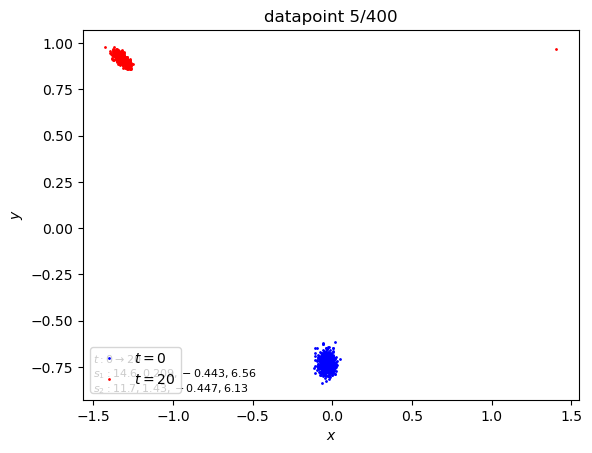

<Axes: title={'center': 'datapoint 5/400'}, xlabel='$x$', ylabel='$y$'>

In [31]:
train_dset.preview(5)

In [3]:
DATASETS = {}

for dataset_key in KEY_LIST:
    for dt0 in DT0_LIST:
        conditions = np.load(f"{DATDIR}/conditions_{dataset_key}_dt_{dt0}.npy")
        times = np.load(f"{DATDIR}/times_{dataset_key}_dt_{dt0}.npy")
        losses = np.load(f"{DATDIR}/losses_{dataset_key}_dt_{dt0}.npy")

        DATASETS[dataset_key, dt0] = {
            'conditions': conditions,
            'times': times,
            'losses': losses,
        }
        


In [4]:
dataset_key = 'test'
dt0 = DT0_LIST[0]

dataset = DATASETS[dataset_key, dt0]
losses = dataset['losses']
times = dataset['times']
nconds, ndata_per_cond, nresamps, nreps = losses.shape

timepoints = np.sort(np.unique(times))
if len(timepoints) > 1:
    timerange = (timepoints[0], timepoints[-1] + timepoints[1] - timepoints[0])
    timepoints += (timepoints[1] - timepoints[0]) / 2
else:
    timerange = (0, 1)
    timepoints += 0.5

print("nconds:", nconds)
print("ndata_per_cond:", ndata_per_cond)
print("nresamps:", nresamps)
print("nreps:", nreps)
print("Timerange:", timerange)
print("nan found?", np.any(np.isnan(losses)))

nconds: 300
ndata_per_cond: 1
nresamps: 1
nreps: 10
Timerange: (0, 1)
nan found? False


Each line is the mean loss of a resampled initial condition, averaged over 10 simulations.


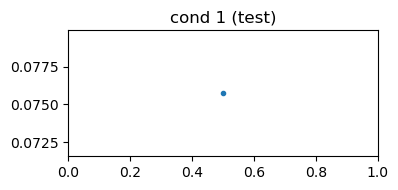

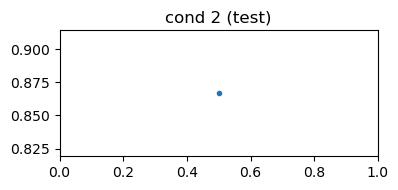

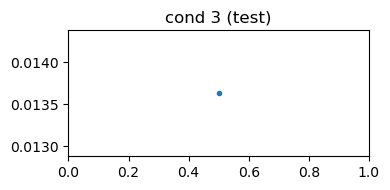

In [5]:
for condidx in range(NCONDS_PLOT):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    cond_name = f"cond {condidx + 1}"
    for sampidx in range(nresamps):
        vals = losses[condidx, :, sampidx, :].mean(1)
        ax.plot(timepoints, vals, '.-')
        ax.set_title(f"{cond_name} ({dataset_key})")
        ax.set_xlim(*timerange)
    
    plt.tight_layout()

print("Each line is the mean loss of a resampled initial condition, averaged over 10 simulations.")

Each line is the mean loss of a condition, averaged over all 1 resamplings.
Error bars show 2 standard deviations.


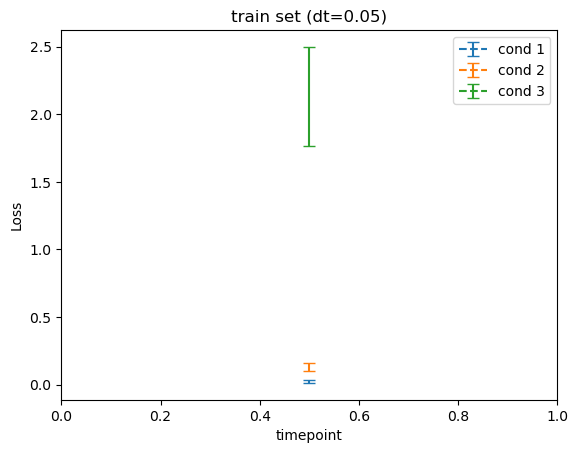

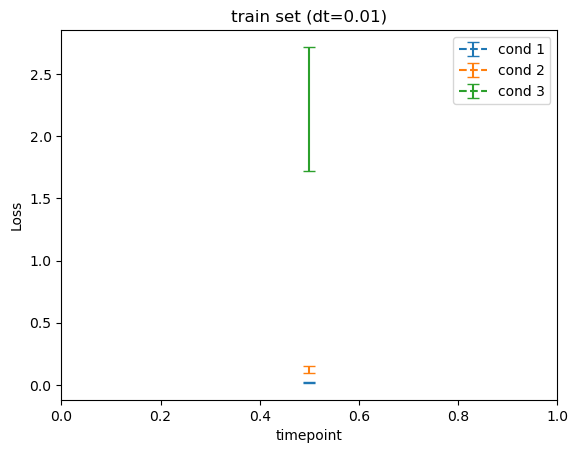

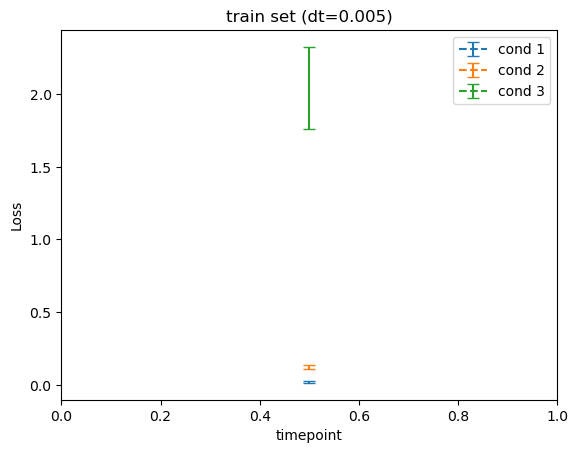

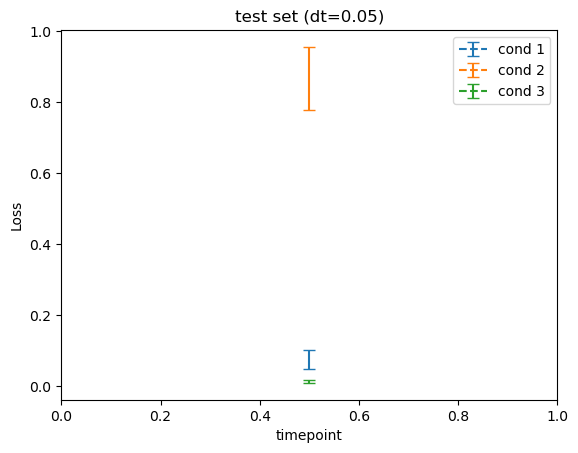

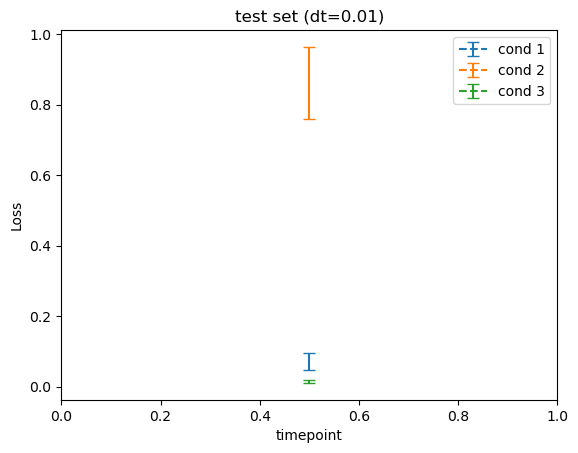

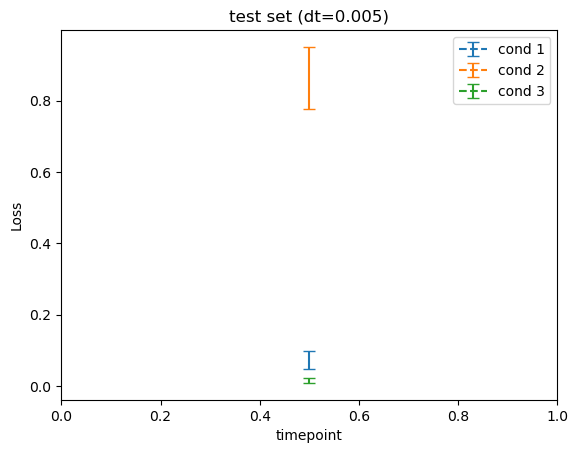

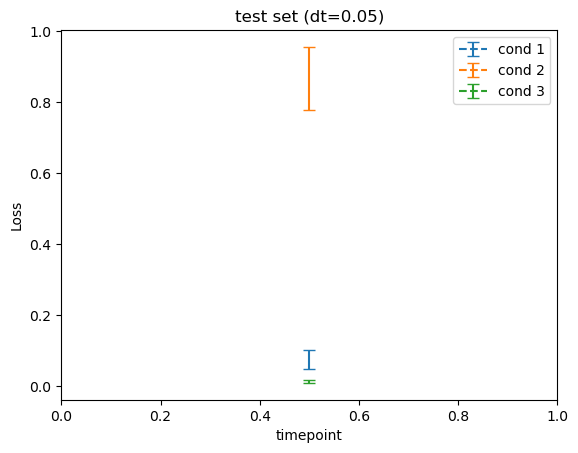

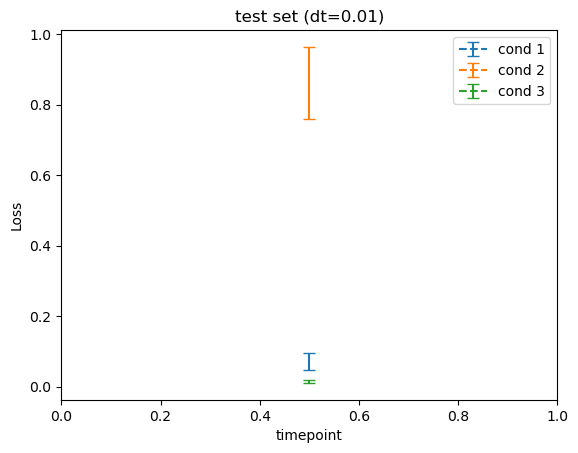

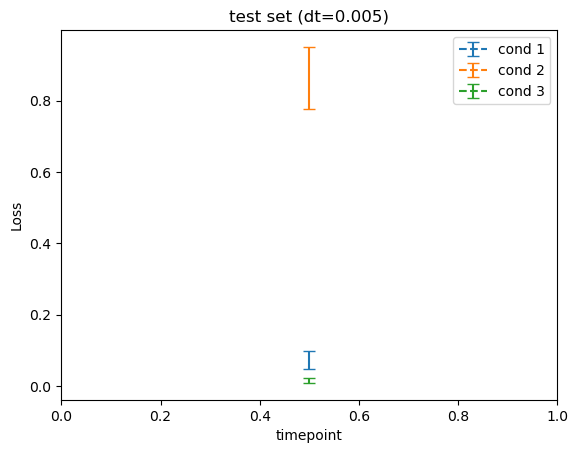

In [6]:
print("Each line is the mean loss of a condition, " \
      f"averaged over all {nresamps} resamplings.")
print("Error bars show 2 standard deviations.")

for dataset_key in KEY_LIST:
    for dt0 in DT0_LIST:
        dataset = DATASETS[dataset_key, dt0]
        losses = dataset['losses']
        times = dataset['times']
        nconds, ndata_per_cond, nresamps, nreps = losses.shape

        fig, ax = plt.subplots(1, 1)
        for condidx in range(NCONDS_PLOT):
            cond_name = f"cond {condidx + 1}"
            mean_loss_over_reps = losses[condidx,:,0,:].mean(-1)
            std_loss_over_reps = losses[condidx,:,0,:].std(-1)
            
            ax.errorbar(
                timepoints, 
                mean_loss_over_reps, 
                yerr=2*std_loss_over_reps,
                capsize=4, linestyle="--", label=cond_name
            )

        ax.set_xlim(*timerange)
        ax.legend()
        ax.set_xlabel("timepoint")
        ax.set_ylabel("Loss")
        ax.set_title(f"{dataset_key} set (dt={dt0})")
        plt.show()
            

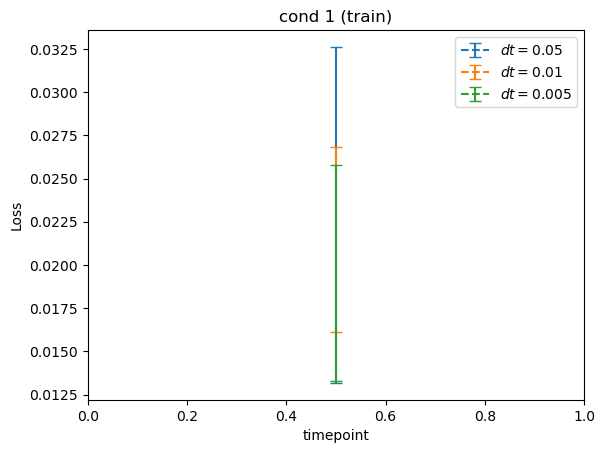

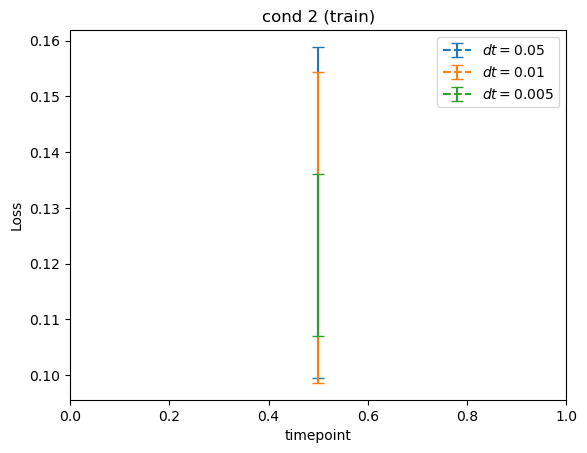

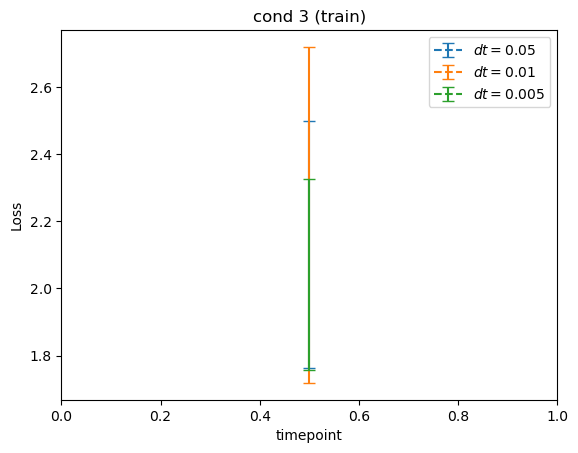

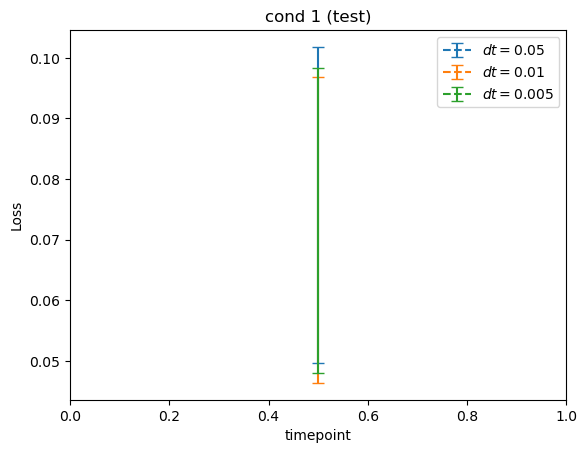

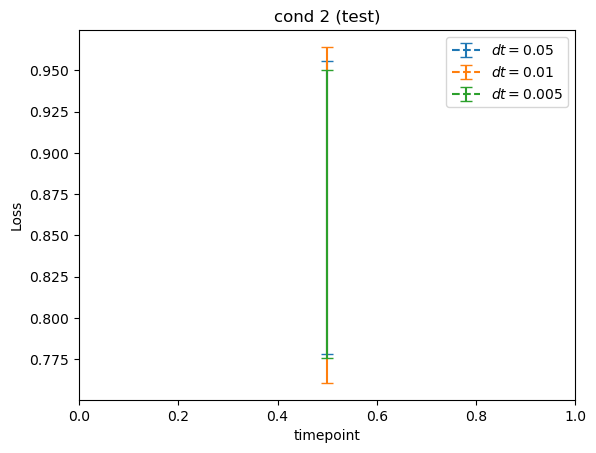

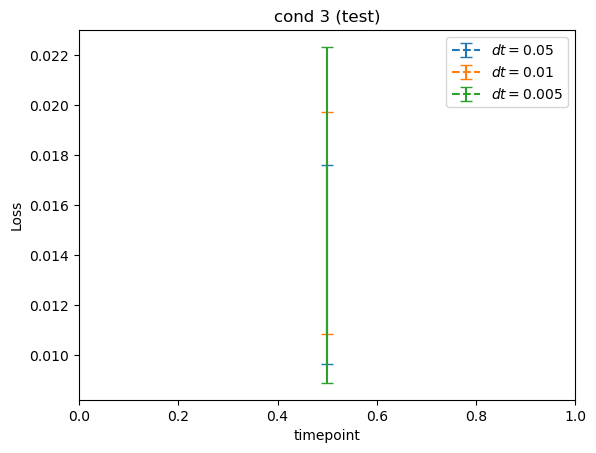

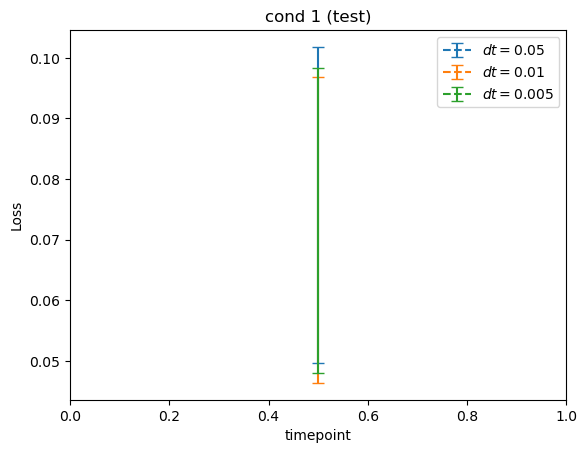

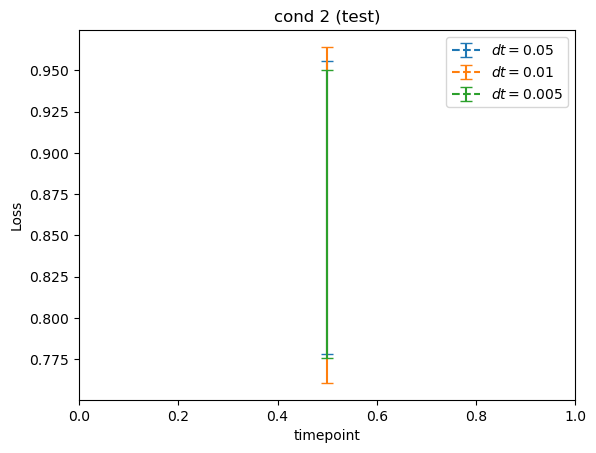

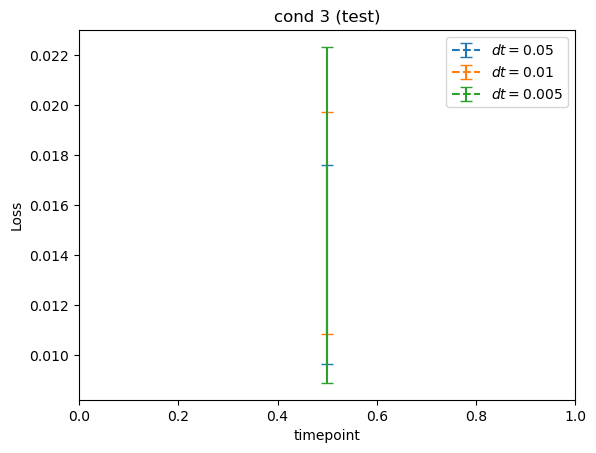

In [7]:
for dataset_key in KEY_LIST:
    dataset = DATASETS[dataset_key, DT0_LIST[0]]
    losses = dataset['losses']
    times = dataset['times']
    nconds, ndata_per_cond, nresamps, nreps = losses.shape    

    for condidx in range(NCONDS_PLOT):
        fig, ax = plt.subplots(1, 1)
        for dt0 in DT0_LIST:
            dataset = DATASETS[dataset_key, dt0]
            losses = dataset['losses']
            times = dataset['times']
            nconds, ndata_per_cond, nresamps, nreps = losses.shape    
            
            cond_name = f"cond {condidx + 1}"
            mean_loss_over_reps = losses[condidx,:,0,:].mean(-1)
            std_loss_over_reps = losses[condidx,:,0,:].std(-1)
            
            ax.errorbar(
                timepoints, 
                mean_loss_over_reps, 
                yerr=2*std_loss_over_reps,
                capsize=4, linestyle="--", label=f"$dt={dt0:.3g}$"
            )

        ax.set_xlim(*timerange)
        ax.legend()
        ax.set_xlabel("timepoint")
        ax.set_ylabel("Loss")
        ax.set_title(f"{cond_name} ({dataset_key})")
        plt.show()
            